In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/MS008_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,MS008-BT,0.0,0.0,0.00500,0.000000,0.0,0.005000,0.0,0.0,0.0
1,MS008-BT,12.0,0.0,1.08115,0.000000,0.0,0.337850,0.0,0.0,0.0
2,MS008-BT,24.0,0.0,0.96386,0.000000,0.0,0.202807,0.0,0.0,0.0
3,MS008-BU,0.0,0.0,0.00000,0.005000,0.0,0.005000,0.0,0.0,0.0
4,MS008-BU,12.0,0.0,0.00000,0.455992,0.0,0.565842,0.0,0.0,0.0


In [3]:
species = ['BU', 'CS']
BT_data = gLV_data.iloc[np.in1d(gLV_data.Treatments.values, [f"Monoculture{sp}" for sp in species])]
BT_data = BT_data[["Treatments", "Time"] + species]
BT_data

,Treatments,Time,BU,CS
200,MonocultureBU,0.0,0.023300,0.000000
201,MonocultureBU,3.0,0.095600,0.000000
202,MonocultureBU,6.0,0.287300,0.000000
203,MonocultureBU,9.0,0.698700,0.000000
204,MonocultureBU,12.0,0.801567,0.000000
205,MonocultureBU,15.0,0.722433,0.000000
206,MonocultureBU,18.0,0.694033,0.000000
207,MonocultureBU,21.0,0.675700,0.000000
208,MonocultureBU,24.0,0.721600,0.000000
209,MonocultureBU,27.0,0.802433,0.000000


# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def plot(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1])
        steps = len(t_eval)
        output, stdv, COV = model.predict_latent(x_test, t_eval)
        # output = model.predict_point(x_test, t_eval)

        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out = output[:,i]
            out_true = output_true[:, i]
            if out[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i))
                plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                plt.fill_between(t_eval, out-stdv[:, i], out+stdv[:, i], color='C{}'.format(i), alpha=0.2)
                
        plt.xlabel("Time (hr)")
        plt.ylabel("Species abundance")
        #plt.legend(loc='upper left')
        plt.title(f"C-R+NN fit to monoculture")
        plt.savefig("figures/CRNN_mono_s.pdf")
        plt.show()
        
        # plot predictions of hidden variables
        for k in range(output.shape[-1] - (i+1)):
            plt.plot(t_eval, np.exp(output[:,i+1+k]), label=f"Predicted R{k+1}", color=f'C{k+1}')
            '''plt.fill_between(t_eval, 
                             np.exp(output[:,i+1+k] - stdv[:,i+1+k]), 
                             np.exp(output[:,i+1+k] + stdv[:,i+1+k]), 
                             color=f'C{k+1}', alpha=0.2)'''

        plt.legend()
        plt.ylabel("Resource concentration")
        plt.xlabel("Time (hr)")
        plt.savefig("figures/CRNN_mono_r.pdf")
        plt.show()

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2
# input includes species, resources and time 
n_x = n_s + n_r 

# dimension of hidden layer
n_h = 8

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# log of death rate 
d = -3*np.ones(n_s)

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)

# maximum consumption rate parameters
p_std = 1./np.sqrt(n_r*n_s)
C = -np.ones([n_r, n_s]) 

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_r, n_s, n_h)

# log of efficiency of species
f = np.zeros(n_s)

# concatenate parameter initial guess
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten(), f.flatten()))

# set prior so that C is sparse 
W1prior = np.zeros_like(W1)
b1prior = np.zeros_like(b1)
Cprior = -10*np.ones([n_r, n_s]) 
W2prior = np.zeros_like(W2)

# concatenate prior 
prior = np.concatenate((d, W1prior.flatten(), b1prior, Cprior.flatten(), W2prior.flatten(), f))

n_params = len(params)
n_params

80

# Define model

In [6]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state (do not include time as an input!)
    state = jnp.concatenate((s, r)) 
    
    # death rate
    d = params[:n_s]
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jax.nn.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jnp.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # attractiveness of resource i to species j  
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h], [n_r, n_s, n_h])
    F  = jax.nn.sigmoid(jnp.einsum("ijk,k->ij", W2, h))
    
    # compute current resource consumption rate 
    C = jnp.einsum('ij,ij->ij', F, Cmax)
    
    # efficiency of species 
    f = jnp.exp(params[n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h:])
    
    # rate of change of species 
    dsdt = s*(f*(C.T@r) - jnp.exp(d)) 

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [7]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

# Fit model to mono culture data

In [8]:
r0 = np.random.uniform(-3, 0, n_r)
#r0 = -np.ones(n_r)
print(r0)

model = ODE(system = system, 
            dataframe=BT_data,
            C=O,
            CRparams = params, 
            r0 = r0,
            prior = prior,
            species = species,
            alpha_0=1e-3,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-4, nlp_tol=1e-4, max_fails=10)
print("Elapsed time {:.2f}s".format(time.time()-t0))

[-2.04370072 -0.92408911]
Updating precision...
Total samples: 88, Updated regularization: 1.00e-03
Total weighted fitting error: 3.198
Total weighted fitting error: 1.844
Total weighted fitting error: 1.536
Total weighted fitting error: 1.039
Total weighted fitting error: 0.565
Total weighted fitting error: 0.417
Total weighted fitting error: 0.338
Total weighted fitting error: 0.304
Total weighted fitting error: 0.280
Total weighted fitting error: 0.274
Total weighted fitting error: 0.271
Total weighted fitting error: 0.267
Total weighted fitting error: 0.259
Total weighted fitting error: 0.254
Total weighted fitting error: 0.245
Total weighted fitting error: 0.245
Total weighted fitting error: 0.240
Total weighted fitting error: 0.232
Total weighted fitting error: 0.231
Total weighted fitting error: 0.229
Total weighted fitting error: 0.229
Total weighted fitting error: 0.227
Total weighted fitting error: 0.225
Total weighted fitting error: 0.224
Total weighted fitting error: 0.222


Evidence 239.847
Updating precision...
Total samples: 88, Updated regularization: 1.75e-06
Total weighted fitting error: 39.063
Total weighted fitting error: 38.543
Total weighted fitting error: 38.330
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 38.33016671340377
       x: [ 2.081e-01 -1.341e+00 ...  9.649e-01 -4.757e-01]
     nit: 3
     jac: [-7.706e+01 -1.540e+02 ... -3.272e+02 -1.426e+00]
    nfev: 5
    njev: 5
    nhev: 3
Evidence 240.564
Updating precision...
Total samples: 88, Updated regularization: 1.81e-06
Total weighted fitting error: 39.090
Total weighted fitting error: 38.878
Total weighted fitting error: 38.875
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 38.87546018075659
       x: [ 2.134e-01 -1.337e+00 ...  9.596e-01 -4.823e-01]
     nit: 3
     jac: [-1.391e+01 -2.070e+01 ... -4.237e+01  8.769e-01]
    nfev: 4
    njev: 4
    nhev: 3
Evidence 241.005
Updating precision...
Total samples: 

Total weighted fitting error: 39.519
Total weighted fitting error: 39.401
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 39.40083345029953
       x: [ 2.033e-01 -9.246e-01 ...  6.794e-01 -5.599e-01]
     nit: 2
     jac: [-3.316e+02  3.555e+02 ...  4.355e+02  7.755e-01]
    nfev: 5
    njev: 5
    nhev: 2
Evidence 252.237
Updating precision...
Total samples: 88, Updated regularization: 3.68e-06
Total weighted fitting error: 40.356
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.35590881319273
       x: [ 2.041e-01 -9.247e-01 ...  6.798e-01 -5.600e-01]
     nit: 1
     jac: [-2.282e+01 -1.323e+01 ... -4.988e+01  4.506e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 252.386
Updating precision...
Total samples: 88, Updated regularization: 3.78e-06
Total weighted fitting error: 40.613
Total weighted fitting error: 40.451
Total weighted fitting error: 40.444
 message: Optimization terminated successfully.
 succe

Total weighted fitting error: 40.998
Total weighted fitting error: 40.927
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 40.92685129978514
       x: [ 1.867e-01 -8.438e-01 ...  6.400e-01 -5.681e-01]
     nit: 2
     jac: [-9.028e+02  7.327e+02 ...  8.334e+02  6.370e+00]
    nfev: 5
    njev: 5
    nhev: 2
Evidence 258.624
Updating precision...
Total samples: 88, Updated regularization: 4.79e-06
Total weighted fitting error: 42.061
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 42.06107939160401
       x: [ 1.867e-01 -8.438e-01 ...  6.400e-01 -5.681e-01]
     nit: 1
     jac: [ 5.442e+01 -5.131e+01 ... -6.612e+01  7.839e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 258.459
Updating precision...
Total samples: 88, Updated regularization: 4.87e-06
Total weighted fitting error: 41.916
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 41.91582677860234
       x: [ 1.868e-01 -8.

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.87480057718747
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-1.001e+01  7.158e+00 ...  1.300e+01 -5.392e-01]
    nfev: 75
    njev: 66
    nhev: 1
Evidence 256.171
Updating precision...
Total samples: 88, Updated regularization: 5.55e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 41.384885203760604
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.128e+00  6.749e+00 ...  1.208e+01 -5.381e-01]
    nfev: 76
    njev: 67
    nhev: 1
Evidence 260.667
Updating precision...
Total samples: 88, Updated regularization: 5.34e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.61645486560232
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     n

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.03721511870388
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.356e+00  6.840e+00 ...  1.232e+01 -5.487e-01]
    nfev: 70
    njev: 62
    nhev: 1
Evidence 257.672
Updating precision...
Total samples: 88, Updated regularization: 5.92e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.13009430299762
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.416e+00  6.866e+00 ...  1.238e+01 -5.429e-01]
    nfev: 74
    njev: 66
    nhev: 1
Evidence 257.760
Updating precision...
Total samples: 88, Updated regularization: 5.82e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.6866245443467
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.06522875100735
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.322e+00  6.824e+00 ...  1.228e+01 -5.435e-01]
    nfev: 68
    njev: 60
    nhev: 1
Evidence 258.733
Updating precision...
Total samples: 88, Updated regularization: 6.24e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.26501310392194
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.438e+00  6.876e+00 ...  1.241e+01 -5.438e-01]
    nfev: 71
    njev: 63
    nhev: 1
Evidence 261.084
Updating precision...
Total samples: 88, Updated regularization: 6.05e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 43.2215990980643
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.48791013822013
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.540e+00  6.922e+00 ...  1.251e+01 -5.436e-01]
    nfev: 78
    njev: 70
    nhev: 1
Evidence 259.975
Updating precision...
Total samples: 88, Updated regularization: 6.40e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.78363015005279
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.720e+00  7.003e+00 ...  1.270e+01 -5.450e-01]
    nfev: 75
    njev: 67
    nhev: 1
Evidence 258.270
Updating precision...
Total samples: 88, Updated regularization: 6.59e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 41.99194372799052
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     ni

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.342022812798106
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.439e+00  6.880e+00 ...  1.241e+01 -5.481e-01]
    nfev: 65
    njev: 57
    nhev: 1
Evidence 259.035
Updating precision...
Total samples: 88, Updated regularization: 6.68e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.51755330452747
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.536e+00  6.924e+00 ...  1.251e+01 -5.481e-01]
    nfev: 70
    njev: 62
    nhev: 1
Evidence 258.472
Updating precision...
Total samples: 88, Updated regularization: 6.56e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 43.05388258694127
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     n

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 43.36688901165149
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-1.003e+01  7.151e+00 ...  1.303e+01 -5.519e-01]
    nfev: 75
    njev: 66
    nhev: 1
Evidence 262.728
Updating precision...
Total samples: 88, Updated regularization: 6.77e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.94874804041329
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.785e+00  7.039e+00 ...  1.277e+01 -5.497e-01]
    nfev: 73
    njev: 64
    nhev: 1
Evidence 257.125
Updating precision...
Total samples: 88, Updated regularization: 6.81e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.80138321198793
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     ni

 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.37397760000782
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.451e+00  6.887e+00 ...  1.242e+01 -5.498e-01]
    nfev: 70
    njev: 61
    nhev: 1
Evidence 256.616
Updating precision...
Total samples: 88, Updated regularization: 7.06e-06
 message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 42.411074511115245
       x: [ 1.775e-01 -8.386e-01 ...  6.440e-01 -5.627e-01]
     nit: 0
     jac: [-9.490e+00  6.904e+00 ...  1.246e+01 -5.535e-01]
    nfev: 67
    njev: 58
    nhev: 1
Evidence 256.595
Elapsed time 90.87s


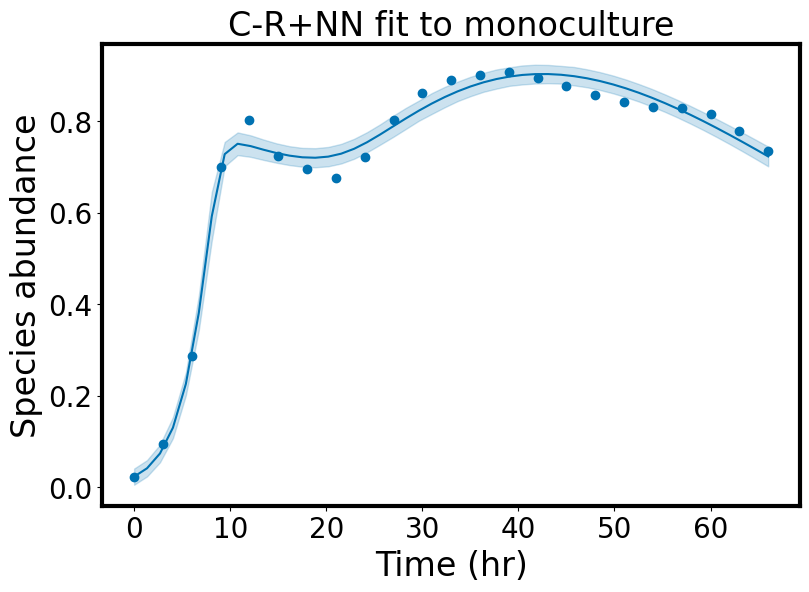

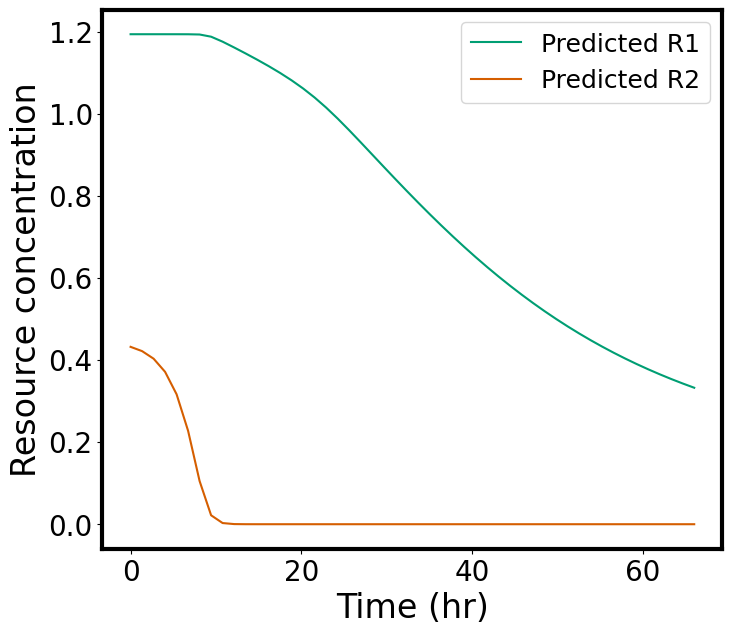

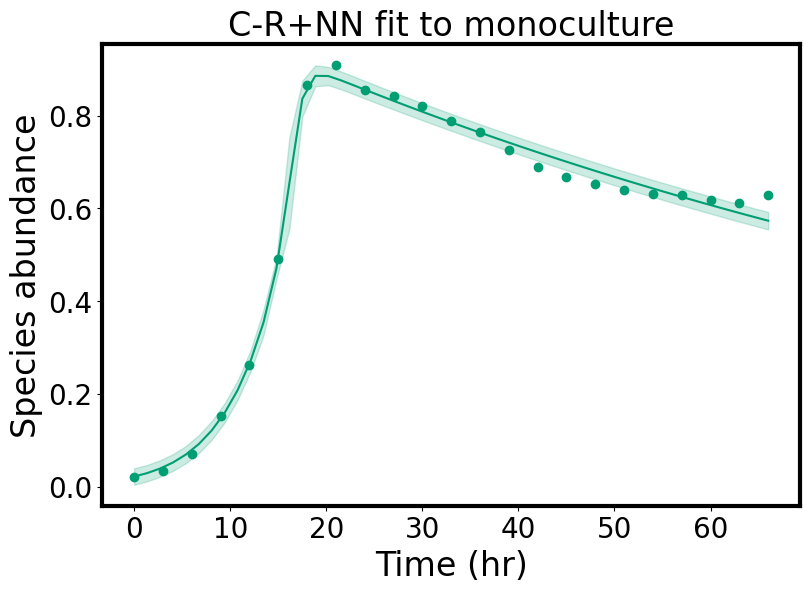

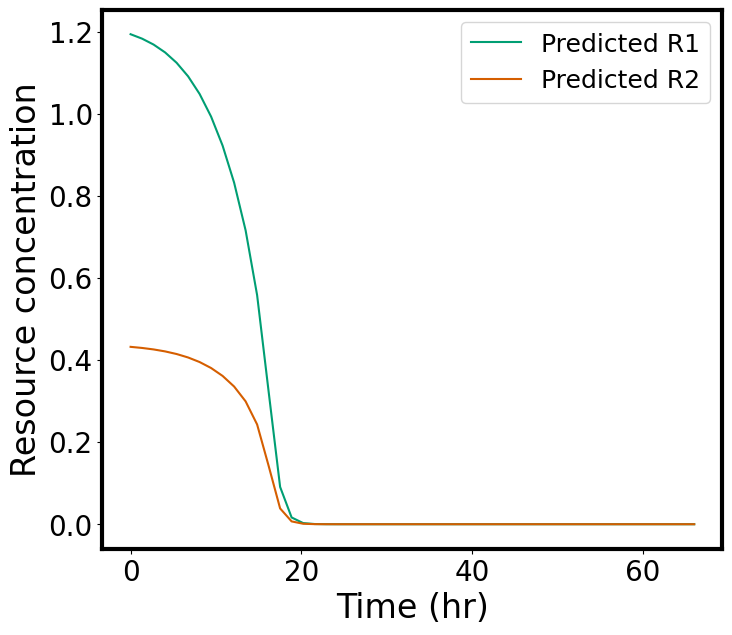

In [9]:
# model.update_precision()
plot(model, BT_data)

In [10]:
r0 = model.params[:n_r]
r0

array([ 0.17754797, -0.83858477])

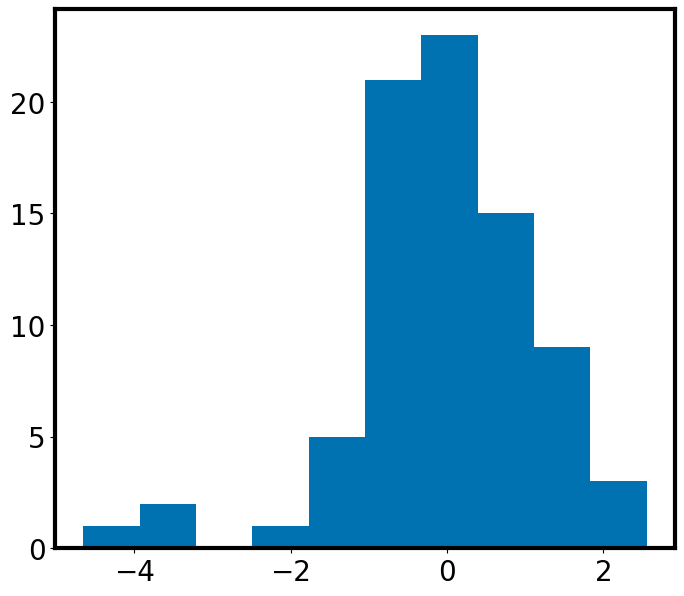

In [11]:
params = model.params[n_r:]
plt.hist(params)
plt.show()

In [12]:
# death rate
d = params[:n_s]
d

array([-3.31267043, -4.65153591])

In [17]:
# efficiency of species 
f = jnp.exp(params[n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h:])
f

DeviceArray([1.9040998 , 0.56969386], dtype=float32)

In [14]:
np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]).T

array([[-3.46741437,  1.28875466],
       [ 0.59753039,  0.51777485]])

In [15]:
# Cmax 
Cmax = np.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
Cmax.T

array([[0.03119759, 3.62826532],
       [1.81762443, 1.67828904]])

In [16]:
model.N

44.0